In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

In [2]:
%%time
train = pd.read_csv('LANL/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 1min 28s


3572471565.388446


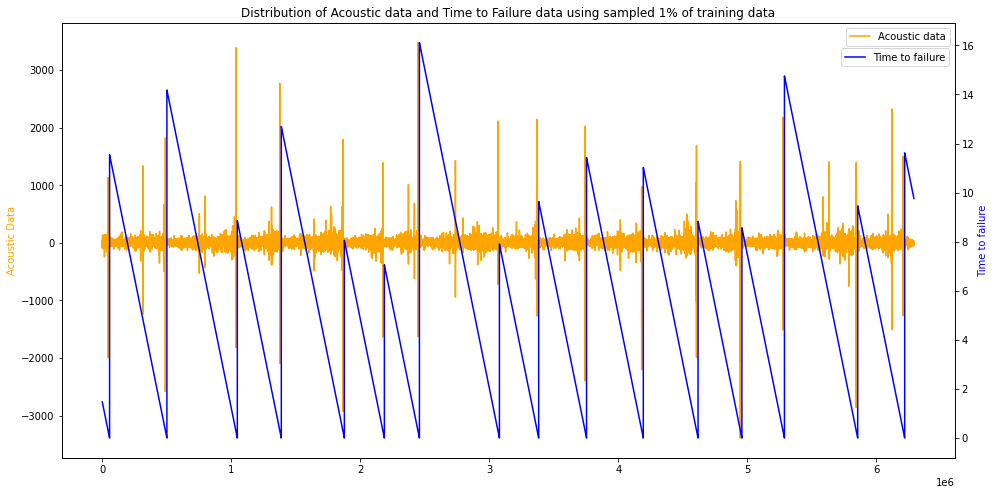

In [3]:
train_acoustic_data_small = train['acoustic_data'].values[::100]
train_time_to_failure_small = train['time_to_failure'].values[::100]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Distribution of Acoustic data and Time to Failure data using sampled 1% of training data")
plt.plot(train_acoustic_data_small, color='orange')
ax1.set_ylabel('Acoustic Data', color='orange')
plt.legend(['Acoustic data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='b')
ax2.set_ylabel('Time to failure', color='b')
plt.legend(['Time to failure'], loc=(.8725, .9))
plt.grid(False)

print(sum(train['time_to_failure']))

In [4]:
del train_acoustic_data_small
del train_time_to_failure_small
train.shape

(629145480, 2)

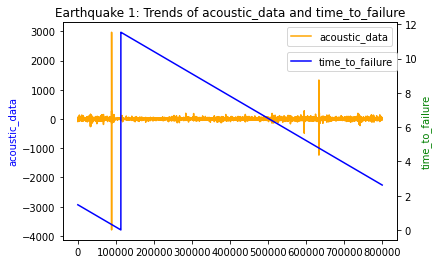

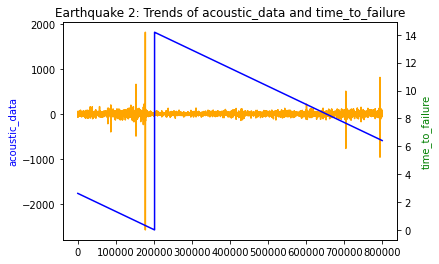

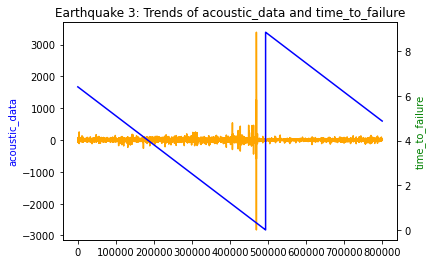

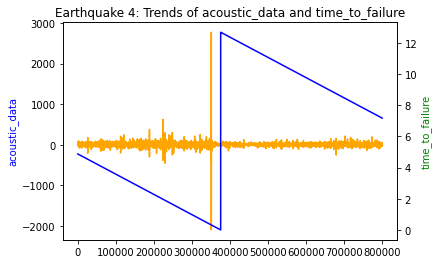

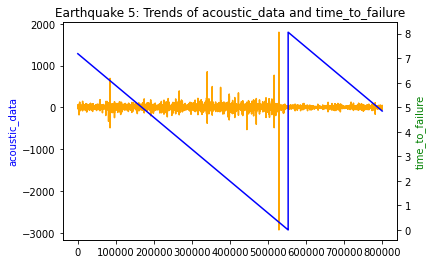

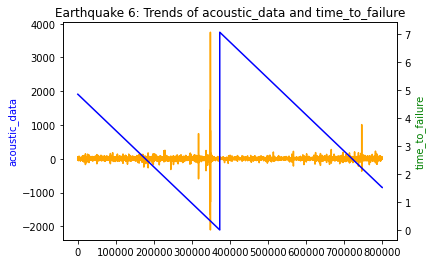

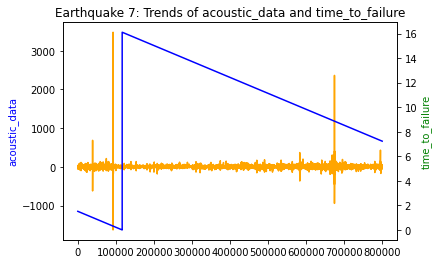

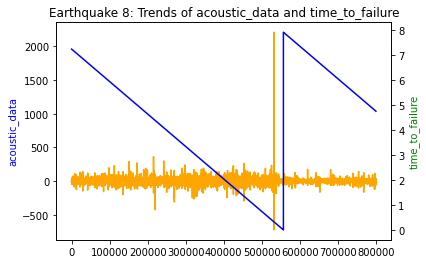

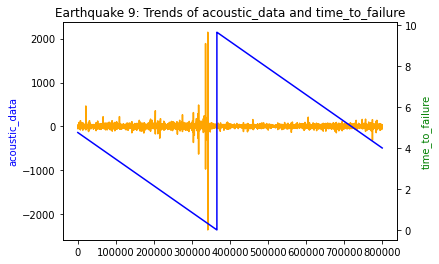

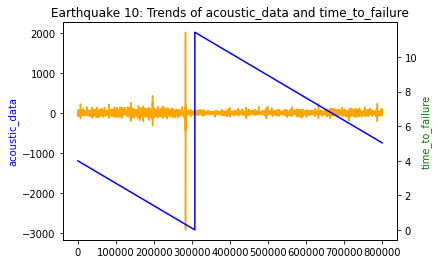

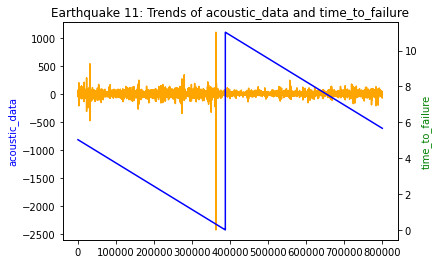

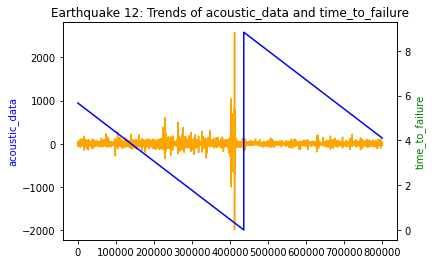

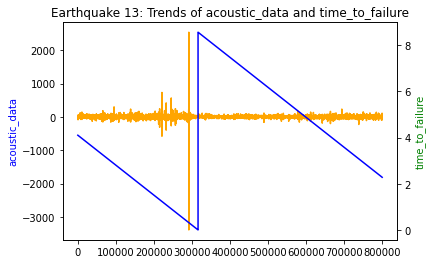

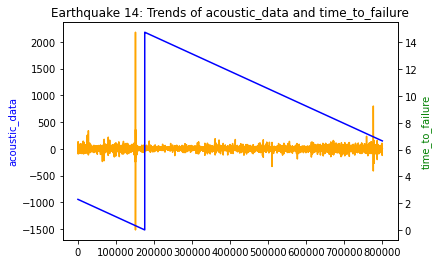

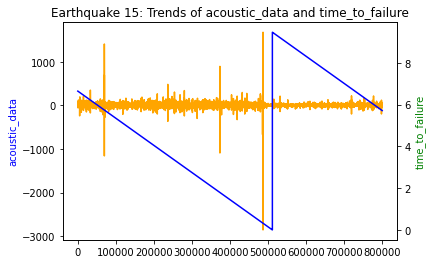

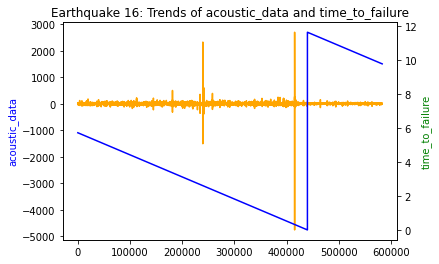

In [5]:
def plotAroundPoints(start, end, i):
    fig, ax1 = plt.subplots(figsize=(6, 4))
    plt.title(f"Earthquake {i+1}: Trends of acoustic_data and time_to_failure")
    plt.plot(train['acoustic_data'].values[start:end:50], color='orange')
    ax1.set_ylabel('acoustic_data', color='b')
    if i==0:
        plt.legend(['acoustic_data'])
    ax2 = ax1.twinx()
    plt.plot(train['time_to_failure'].values[start:end:50], color='b')
    ax2.set_ylabel('time_to_failure', color='g')
    if i == 0:
        plt.legend(['time_to_failure'], loc=(.67, .775))

j=0
for i in range(16):
    
    plotAroundPoints(j, j + 40000000, i)
    j+=40000000
    


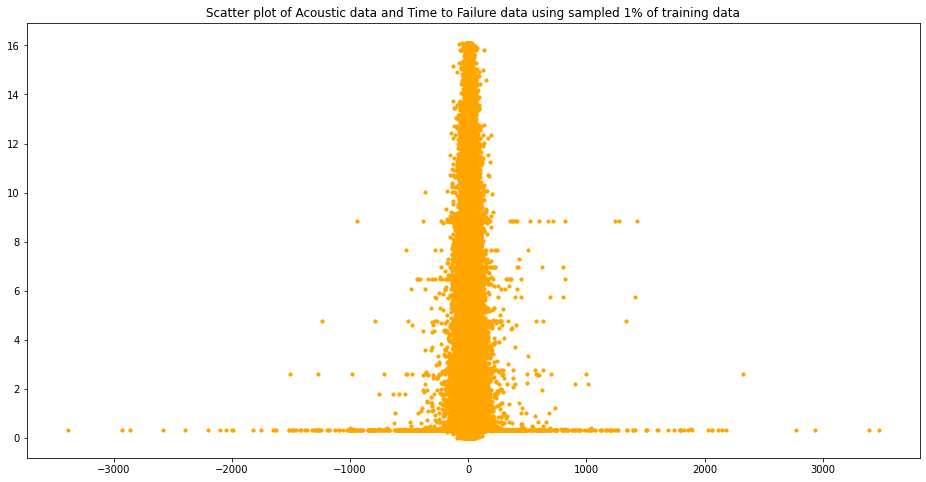

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.scatter(train['acoustic_data'].values[::100], train['time_to_failure'].values[::100], s=10, color='orange')
plt.title("Scatter plot of Acoustic data and Time to Failure data using sampled 1% of training data")

plt.show()

Acoustic Signal for segments seg_3ba485.csv to seg_3d06cc.csv 


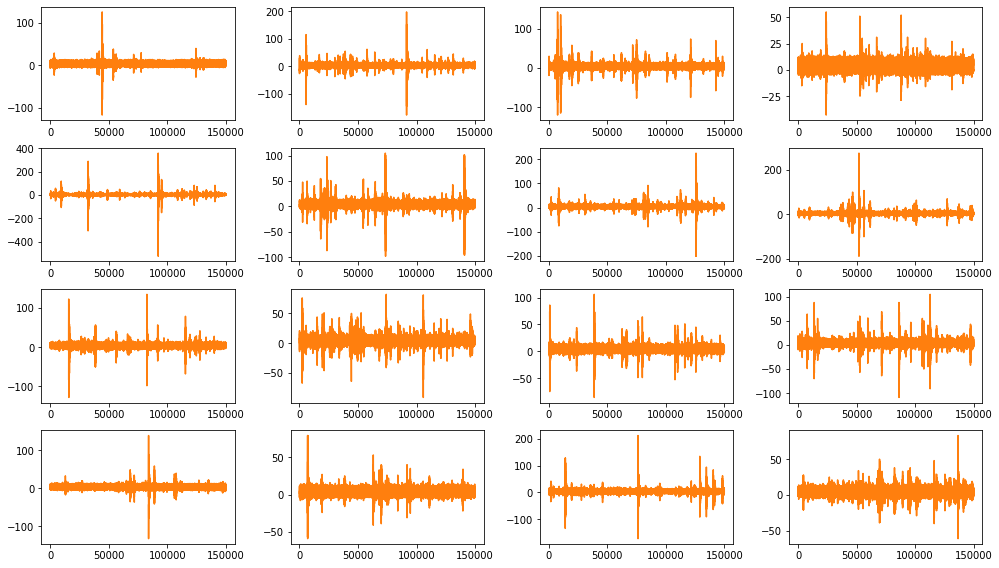

In [14]:
# plot test signals
import sys
TEST_DIR = './LANL/test/'  # set for local environment!

np.random.seed(122020)
rand_idx = int(np.random.randint(0, 2608, size=1, dtype=np.int32))

ld = os.listdir(TEST_DIR)
ld = ld[rand_idx:rand_idx+16]

f, axes = plt.subplots(4, 4, figsize=(14, 8))
i = 0
j = 0
    
for sig_file in ld:
    sig = pd.read_csv(os.path.join(TEST_DIR, sig_file))['acoustic_data']
    axes[j][i].set_ylabel = sig    
    axes[j][i].plot(sig, color='tab:orange')
  
    
    i += 1
    if i >= 4:
        i = 0
        j += 1

print(f"Acoustic Signal for segments {ld[0]} to {ld[15]} ")
plt.tight_layout()
plt.show()
del sig

In [12]:
from tqdm import tqdm #Makes iterations look better
from scipy.stats import kurtosis, skew
from statsmodels.robust import mad
segment_size = 150000
num_segments = int(np.floor(train.shape[0]/segment_size))

X_train = pd.DataFrame(index=range(num_segments),columns=['ave','std','min','max'],dtype=np.float64)
y_train = pd.DataFrame(index=range(num_segments),columns=['time_to_failure'],dtype=np.float64)

for i in tqdm(range(num_segments)):
    segment_i = train.iloc[i*segment_size:i*segment_size+segment_size]
    x = segment_i['acoustic_data'].values
    y = segment_i['time_to_failure'].values[-1]
    X_train.loc[i,'ave'] = x.mean()
    X_train.loc[i,'std'] = x.std()
    X_train.loc[i,'max'] = x.max()
    X_train.loc[i,'min'] = x.min()
    X_train.loc[i,'kurtosis'] = kurtosis(x)
    X_train.loc[i,'skew'] = skew(x)
    X_train.loc[i,'mad'] = mad(x)
    
    y_train.loc[i,'time_to_failure'] = y
    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4194/4194 [00:49<00:00, 84.69it/s]


In [25]:
submission_files = pd.read_csv('./LANL/sample_submission.csv',index_col='seg_id')
submission_files

X_test = pd.DataFrame(columns=X_train.columns,index=submission_files.index,dtype=np.float64)

for seg_id in tqdm(X_test.index):
    segment = pd.read_csv(TEST_DIR+seg_id+'.csv')
    x = segment['acoustic_data'].values
  
    X_test.loc[seg_id,'ave'] = x.mean()
    X_test.loc[seg_id,'std'] = x.std()
    X_test.loc[seg_id,'max'] = x.max()
    X_test.loc[seg_id,'min'] = x.min()
    X_test.loc[seg_id,'kurtosis'] = kurtosis(x)
    X_test.loc[seg_id,'skew'] = skew(x)
    X_test.loc[seg_id,'mad'] = mad(x)
X_test

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2624/2624 [01:03<00:00, 41.43it/s]


,ave,std,min,max,kurtosis,skew,mad
seg_id,,,,,,,
seg_00030f,4.491780,4.893673,-75.0,115.0,28.836567,0.327904,2.965204
seg_0012b5,4.171153,5.922820,-140.0,152.0,56.217041,0.295705,2.965204
seg_00184e,4.610260,6.946967,-193.0,248.0,162.112840,0.428684,2.965204
seg_003339,4.531473,4.114133,-93.0,85.0,41.240413,0.061889,2.965204
seg_0042cc,4.128340,5.797144,-147.0,177.0,79.537016,0.073898,2.965204
...,...,...,...,...,...,...,...
seg_ff4236,4.095773,5.082426,-50.0,71.0,12.280456,-0.001993,2.965204
seg_ff7478,4.138493,6.031576,-208.0,164.0,132.557911,-0.843307,2.965204
seg_ff79d9,3.748587,9.467500,-303.0,310.0,202.478046,-0.472015,4.447807


In [35]:
y_train.shape

X_train.shape

(4194, 7)

In [44]:
print(f'X_train:{X_train.shape} y_train:{y_train.shape}\nX_test:{X_test.shape}')


X_train:(4194, 7) y_train:(4194, 1)
X_test:(2624, 7)


In [ ]:

def plotresult(test, pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(test, pred)
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('Actual', fontsize=11)
    plt.ylabel('Predicted', fontsize=11)
    plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
    plt.show()
    
plotresult(y2_test, y_test_pred)

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

X1_train, X1_test, y1_train, y1_test = train_test_split(train['acoustic_data'].values[::25].reshape(-1, 1), train['time_to_failure'].values[::25], test_size=0.2)

quake_linear_model1 = LinearRegression()
quake_linear_model1.fit(X1_train, y1_train)

y_train_pred = quake_linear_model1.predict(X1_train)
y_test_pred = quake_linear_model1.predict(X1_test)

r2_train_score = r2_score(y1_train, y_train_pred)
mae_train_score = median_absolute_error(y1_train, y_train_pred)
r2_test_score = r2_score(y1_test, y_test_pred)
mae_test_score = median_absolute_error(y1_test, y_test_pred)

print(f"R2 score for training data: {r2_train_score:0.6f} and for the test data: {r2_test_score:0.6f}")
print(f"Mean Absolute Error score for training data: {mae_train_score:0.3f} and for the test data: {mae_test_score:0.3f}")


R2 score for training data: 0.000000 and for the test data: 0.000001
Mean Absolute Error score for training data: 2.805 and for the test data: 2.805


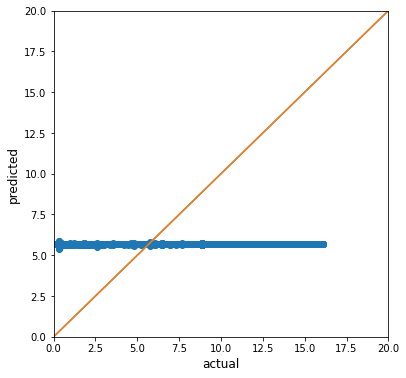

[['Linear Regression Model with 4% Sampled data', 2.8051015862098216]]


In [90]:
plotresult(y1_test, y_test_pred)
m_score = ['Linear Regression Model with 4% Sampled data',mae_test_score]
score = [m_score]
print(score)

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_train_scaled, y_train.values.flatten(), test_size=0.2)

quake_linear_model2 = LinearRegression()
quake_linear_model2.fit(X2_train, y2_train)

y_train_pred = quake_linear_model2.predict(X2_train)
y_test_pred = quake_linear_model2.predict(X2_test)

r2_train_score = r2_score(y2_train, y_train_pred)
mae_train_score = median_absolute_error(y2_train, y_train_pred)
r2_test_score = r2_score(y2_test, y_test_pred)
mae_test_score = median_absolute_error(y2_test, y_test_pred)

print(f"R2 score for training data: {r2_train_score:0.6f} and for the test data: {r2_test_score:0.6f}")
print(f"Mean Absolute Error score for training data: {mae_train_score:0.3f} and for the test data: {mae_test_score:0.3f}")

R2 score for training data: 0.238598 and for the test data: 0.240367
Mean Absolute Error score for training data: 2.058 and for the test data: 2.149


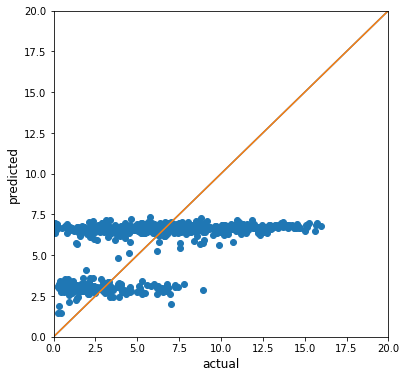

[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869]]


In [93]:
plotresult(y2_test, y_test_pred)

m_score = ['Linear Regression Model with statistical features',mae_train_score]

score.append(m_score)
print(score)


In [95]:
from sklearn.svm import NuSVR
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y3_pred = svm.predict(X_train_scaled)

mae_score = median_absolute_error(y_train.values.flatten(), y3_pred)
print(f'Mean Absolute Error score for data:  {mae_score:0.3f}')

Mean Absolute Error score for data:  1.765


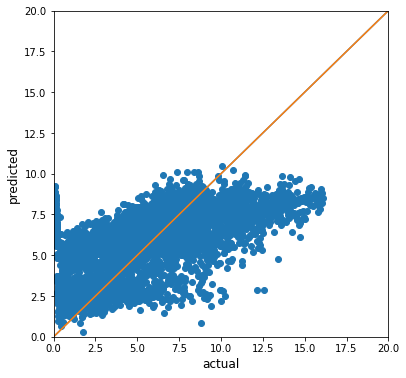

[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869], ['SVM Model', 1.7654601810750177]]


In [94]:
plotresult(y_train.values.flatten(), y3_pred)

m_score = ['SVM Model',mae_score]
score.append(m_score)
print(score)

In [96]:
train['acoustic_data'].values[::25].shape

(25165820,)

In [156]:
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_train_X = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
display(scaled_train_X)
train_y = pd.DataFrame(y_train)
display(train_y)
scaled_test_X = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

train_columns = scaled_train_X.columns.values


,ave,std,min,max,kurtosis,skew,mad
0,1.424140,-0.170214,0.193218,-0.218194,-0.491310,-0.313703,-0.578003
1,0.805716,0.004734,-0.018037,0.063936,0.431696,0.553891,-0.578003
2,1.511155,0.049252,0.163039,-0.086289,-0.492831,0.191534,1.531785
3,1.494934,0.043950,-0.187796,0.122560,0.683938,1.321245,-0.578003
4,1.520242,0.088495,0.087590,-0.067969,-0.217434,-0.128324,-0.578003
...,...,...,...,...,...,...,...
4189,-0.285562,-0.332427,0.332798,-0.320786,-0.628932,-0.299501,-0.578003
4190,-0.412699,-0.310125,0.336570,-0.298802,-0.558229,0.075533,-0.578003
4191,0.342653,-0.391250,0.415791,-0.368418,-0.827008,0.033792,-0.578003
4192,-0.211617,-0.280840,0.196991,-0.254834,-0.106844,-0.201179,-0.578003


,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400
...,...
4189,9.926798
4190,9.887500
4191,9.849197
4192,9.809799


In [153]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 122020}

In [157]:
import xgboost as xgb
import lightgbm as lgb

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    #print(X_tr,X_val)
    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1, verbose_eval=False)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.18873	valid_1's l1: 2.3826
[2000]	training's l1: 1.927

Early stopping, best iteration is:
[3879]	training's l1: 1.69689	valid_1's l1: 2.12671
fold 7
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 50

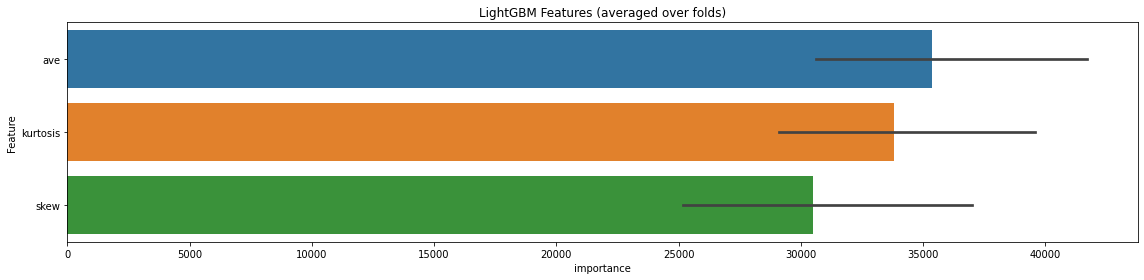

In [142]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:3].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(16,4))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [155]:
print(score)
#m_score = ['LightGBM',1.69579]
#score.append(m_score)
print(score)

[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869], ['SVM Model', 1.7654601810750177], ['LightGBM', 1.69579]]
[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869], ['SVM Model', 1.7654601810750177], ['LightGBM', 1.69579]]


In [159]:
def train_model(X=scaled_train_X, X_test=scaled_test_X, y=train_y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [162]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=scaled_train_X, X_test=scaled_test_X, params=xgb_params, model_type='xgb')

Fold 0 started at Wed Dec 16 22:27:23 2020
[22:27:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:27:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:5.07882	valid_data-mae:4.95059
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[101]	train-mae:1.31234	valid_data-mae:2.20388

[22:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:l

[22:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Fold 8 started at Wed Dec 16 22:27:29 2020
[22:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:27:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:5.05085	valid_data-mae:5.20060
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best itera

Fold 0 started at Wed Dec 16 22:30:07 2020
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_fraction is set=0.8126672064208567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126672064208567
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1410]	training's l1: 1.91161	valid_1's l1: 2.15748
Fold 1 started at Wed Dec 16 22:30:08 2020
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_fraction is set=0.812

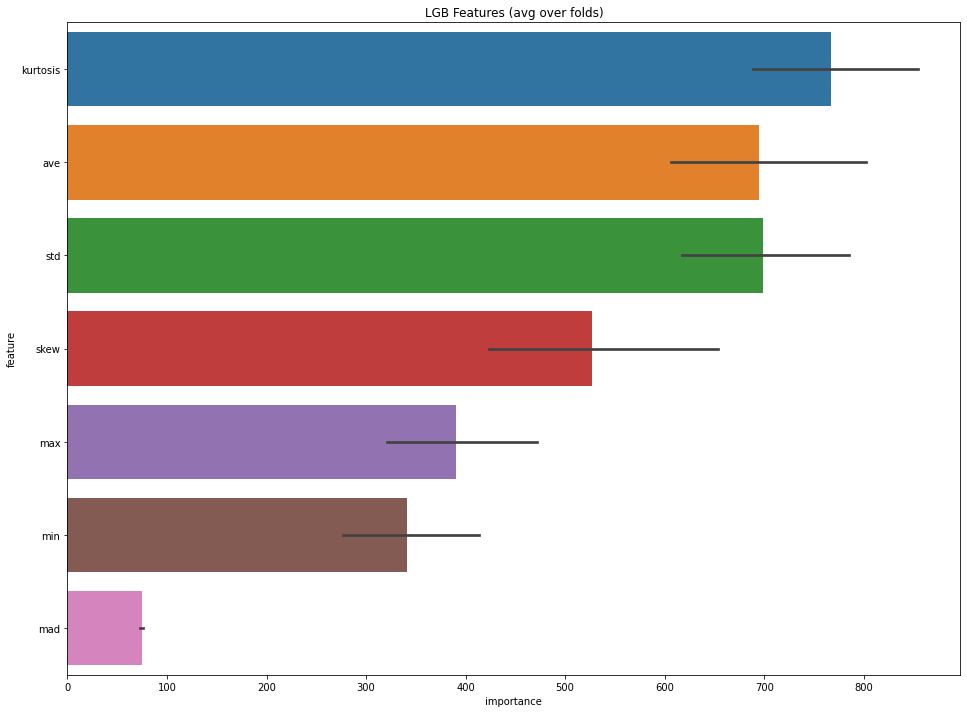

In [163]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X=scaled_train_X, X_test=scaled_test_X, params=params, model_type='lgb', plot_feature_importance=True)

In [196]:
def my_regression_results(model,title):
    score_test = model.score(X4_test,y4_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))

    y4_pred = model.predict(X4_test)
    # import matplotlib.pyplot as plt
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.plot(y4_test,y4_pred,'k.',color = 'orange')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    # from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y4_test,y4_pred)
    mae = mean_absolute_error(y4_test,y4_pred)
    rmse = np.sqrt(mse)
    #print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Mean absolute error on test data: {:0.2f}'.format(mae))
    #print('Root mean squared error on test data: {:0.2f}'.format(rmse))

In [199]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# import xgboost as xgb
X4_train, X4_test, y4_train, y4_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123)


xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror',eval_metric = 'mae')
xgbr_model.fit(X4_train,y4_train)

params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth": randint(1, 10),
    "n_estimators": randint(10, 100),
    "subsample": uniform(0.05, 0.95),  # so uniform on [.05,.05+.95] = [.05,1.]
    "min_child_weight": randint(1, 20),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    xgbr_model,
    param_distributions=params,
    random_state=8675309,
    n_iter=500,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

random_search.fit(X4_train, y4_train)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, eval_metric='mae',
                                          gamma=0, gpu_id=-1,
                                          importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=10...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BD8C47B148>,
                

Model r-squared score from test data: 0.4289
Mean absolute error on test data: 2.11


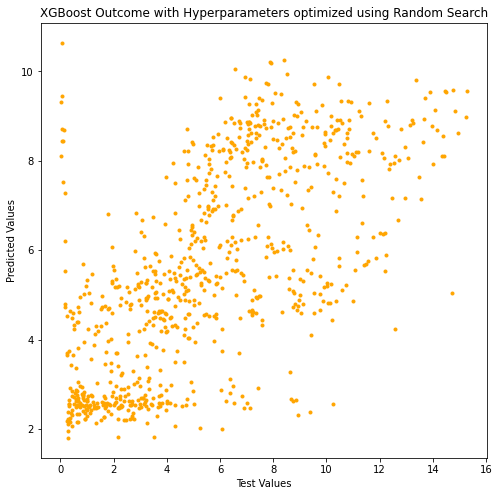

In [201]:
my_regression_results(random_search,"XGBoost Outcome with Hyperparameters optimized using Random Search")

In [194]:
random_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 13,
 'n_estimators': 75,
 'reg_alpha': 1.444481602926766,
 'reg_lambda': 0.13064716849099933,
 'subsample': 0.7295165433964556}

In [186]:
# unfold to see code
np.random.seed(8675309)  # seed courtesy of Tommy Tutone
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import cross_val_score, KFold

hp_bounds = [{
    'name': 'learning_rate',
    'type': 'continuous',
    'domain': (0.001, 1.0)
}, {
    'name': 'max_depth',
    'type': 'discrete',
    'domain': (1, 10)
}, {
    'name': 'n_estimators',
    'type': 'discrete',
    'domain': (10, 100)
}, {
    'name': 'subsample',
    'type': 'continuous',
    'domain': (0.05, 1.0)
}, {
    'name': 'min_child_weight',
    'type': 'discrete',
    'domain': (1, 20)
}, {
    'name': 'reg_alpha',
    'type': 'continuous',
    'domain': (0, 5)
}, {
    'name': 'reg_lambda',
    'type': 'continuous',
    'domain': (0, 5)
}]


# Optimization objective
def cv_score(hyp_parameters):
    hyp_parameters = hyp_parameters[0]
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 learning_rate=hyp_parameters[0],
                                 max_depth=int(hyp_parameters[1]),
                                 n_estimators=int(hyp_parameters[2]),
                                 subsample=hyp_parameters[3],
                                 min_child_weight=int(hyp_parameters[4]),
                                 reg_alpha=hyp_parameters[5],
                                 reg_lambda=hyp_parameters[6])
    scores = cross_val_score(xgb_model,
                             X=X4_train,
                             y=y4_train,
                             cv=KFold(n_splits=5))
    return np.array(scores.mean())  # return average of 5-fold scores


optimizer = BayesianOptimization(f=cv_score,
                                 domain=hp_bounds,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 acquisition_jitter=0.05,
                                 exact_feval=True,
                                 maximize=True,
                                 verbosity=True)

optimizer.run_optimization(max_iter=20,verbosity=True)






num acquisition: 1, time elapsed: 0.34s
num acquisition: 2, time elapsed: 0.79s
num acquisition: 3, time elapsed: 1.19s
num acquisition: 4, time elapsed: 1.44s
num acquisition: 5, time elapsed: 1.97s
num acquisition: 6, time elapsed: 2.37s
num acquisition: 7, time elapsed: 2.76s
num acquisition: 8, time elapsed: 3.01s
num acquisition: 9, time elapsed: 3.40s
num acquisition: 10, time elapsed: 3.72s
num acquisition: 11, time elapsed: 4.09s
num acquisition: 12, time elapsed: 4.39s
num acquisition: 13, time elapsed: 4.78s
num acquisition: 14, time elapsed: 5.10s
num acquisition: 15, time elapsed: 5.53s
num acquisition: 16, time elapsed: 5.81s
num acquisition: 17, time elapsed: 6.15s
num acquisition: 18, time elapsed: 6.57s
num acquisition: 19, time elapsed: 6.99s
num acquisition: 20, time elapsed: 7.35s


In [187]:
best_hyp_set = {}
for i in range(len(hp_bounds)):
    if hp_bounds[i]['type'] == 'continuous':
        best_hyp_set[hp_bounds[i]['name']] = optimizer.x_opt[i]
    else:
        best_hyp_set[hp_bounds[i]['name']] = int(optimizer.x_opt[i])
best_hyp_set

{'learning_rate': 0.12183284948100732,
 'max_depth': 1,
 'n_estimators': 100,
 'subsample': 0.31779897795352685,
 'min_child_weight': 20,
 'reg_alpha': 3.6014342172321645,
 'reg_lambda': 1.9640072083476605}

In [202]:
bayopt_search = xgb.XGBRegressor(objective='reg:squarederror',**best_hyp_set)
bayopt_search.fit(X4_train,y4_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.12183284948100732, max_delta_step=0, max_depth=1,
             min_child_weight=20, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=3.6014342172321645, reg_lambda=1.9640072083476605,
             scale_pos_weight=1, subsample=0.31779897795352685,
             tree_method='exact', validate_parameters=1, verbosity=None)

Model r-squared score from test data: 0.4197
Mean absolute error on test data: 2.14


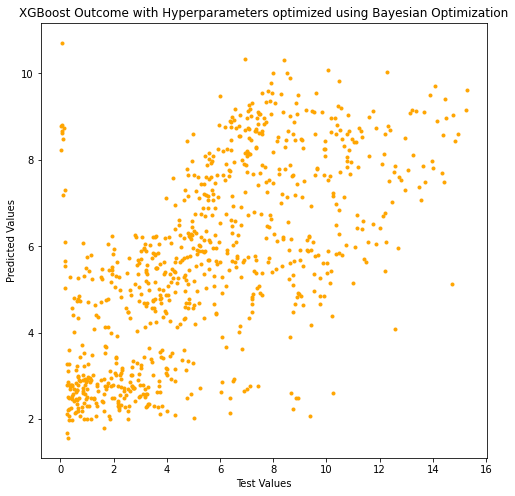

In [204]:
my_regression_results(bayopt_search,"XGBoost Outcome with Hyperparameters optimized using Bayesian Optimization")

In [215]:
from pycaret.regression import *

#Load loan data
X = pd.concat([X_train,y_train],axis = 1)
exp1 = setup(X, target='time_to_failure')


,Description,Value
0,session_id,593
1,Target,time_to_failure
2,Original Data,"(4194, 8)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2935, 7)"


In [216]:
models()


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [218]:
xgbc_model = create_model('xgboost')


IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:57:58
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,MAE,MSE,RMSE,R2,RMSLE,MAPE


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [222]:
print(score)
m_score = ['XGBoost - Optimized by Random Search Hyperparameter Optimization',2.11]
score.append(m_score)

print(score)
m_score = ['XGBoost - Optimized by Bayesian Hyperparameter Optimization',2.14]
score.append(m_score)
print(score)




[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869], ['SVM Model', 1.7654601810750177], ['LightGBM', 1.69579]]
[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869], ['SVM Model', 1.7654601810750177], ['LightGBM', 1.69579], ['XGBoost - Optimized by Random Search Hyperparameter Optimization', 2.11]]
[['Linear Regression Model with 4% Sampled data', 2.8051015862098216], ['Linear Regression Model with statistical features', 2.0583869056869], ['SVM Model', 1.7654601810750177], ['LightGBM', 1.69579], ['XGBoost - Optimized by Random Search Hyperparameter Optimization', 2.11], ['XGBoost - Optimized by Bayesian Hyperparameter Optimization', 2.14]]


,Algorithm,MAE
Algorithm,,
Linear Regression Model with 4% Sampled data,Linear Regression Model with 4% Sampled data,2.805102
Linear Regression Model with statistical features,Linear Regression Model with statistical features,2.058387
SVM Model,SVM Model,1.765460
LightGBM,LightGBM,1.695790
XGBoost - Optimized by Random Search Hyperparameter Optimization,XGBoost - Optimized by Random Search Hyperpara...,2.110000
XGBoost - Optimized by Bayesian Hyperparameter Optimization,XGBoost - Optimized by Bayesian Hyperparameter...,2.140000


<Figure size 1152x576 with 0 Axes>

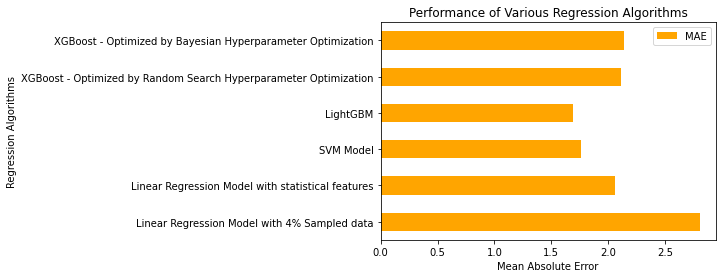

In [247]:
final_score = pd.DataFrame(score, columns=['Algorithm','MAE'])
final_score.index =final_score['Algorithm']
display(final_score)
plt.figure(figsize=(16, 8))
ax = final_score.plot(kind='barh', color='Orange')
ax.set_title("Performance of Various Regression Algorithms")
ax.set_ylabel('Regression Algorithms')
ax.set_xlabel('Mean Absolute Error')
#plt.tight_layout()
plt.savefig('final_comparison')
